checking out the mesh samplers... using https://github.com/yt-project/yt/pull/4398 to sample multiple points at once

### 3D, linear, hexahedral mesh element

8 nodes, check check yt/utilities/mesh_types.yaml for node ordering for vert ordering 

signature for `sample_at_real_points`: 

returns sample values array:
```python
 def sample_at_real_points(self,
                               np.float64_t[:,::1] vertices,
                               np.float64_t[::1] field_values,
                               np.float64_t[:,::1] positions):
```


In [53]:
#  3D, linear, hexahedral mesh element has 8 nodes 
import numpy as np
from yt.utilities.lib.element_mappings import Q1Sampler3D, Q1Sampler2D
import matplotlib.pyplot as plt 

hex_sampler = Q1Sampler3D() 


verts = [[0., 0., 0.], 
         [1., 0., 0.], 
         [1., 1., 0.], 
         [0., 1., 0.],
         [0., 0., 1.], 
         [1., 0., 1.], 
         [1., 1., 1.], 
         [0., 1., 1.]]
verts = np.array(verts)

field_vals = np.random.random((8,))

positions_to_sample = verts.copy() # should return exact


sampled_values = hex_sampler.sample_at_real_points(verts, field_vals, positions_to_sample)
assert(np.allclose(sampled_values, field_vals))


# set field values to vary from one side to the other 
field_vals = np.full((8,), 5.) * (verts[:,2] == 1)

# sample along z, should vary linearly from 0 to 5.
nsamples = 100
y_samples = np.full((nsamples,), 0.5)
x_samples = np.full((nsamples,), 0.5)
z_samples = np.linspace(0,1,nsamples)

positions_to_sample = np.column_stack([x_samples, y_samples, z_samples])
positions_to_sample.shape
sampled_values = hex_sampler.sample_at_real_points(verts, field_vals, positions_to_sample)
assert(np.allclose(sampled_values, z_samples * 5.0))


### plot within the element

In [54]:

x0 = np.linspace(0,1,20)
y0 = np.linspace(0,1,25)
z0 = np.full((10,),0.5)
xg, yg, zg = np.meshgrid(x0, y0, z0, indexing='ij')
positions_to_sample = np.column_stack([xg.ravel(), yg.ravel(), zg.ravel()])

field_vals = np.random.random((8,))
sampled_values = hex_sampler.sample_at_real_points(verts, field_vals, positions_to_sample)
sampled_values = sampled_values.reshape(xg.shape)

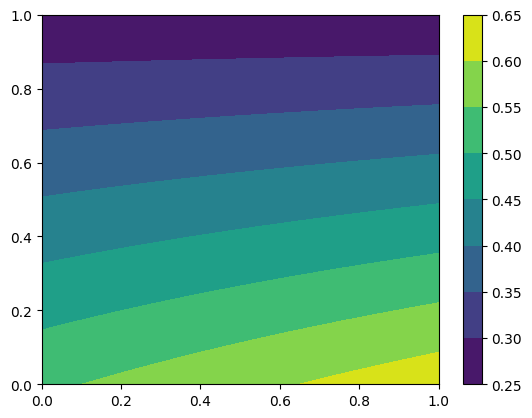

In [55]:
import matplotlib.pyplot as plt 

plt.contourf(y0, x0, sampled_values[:,:,0])
plt.colorbar()

In [56]:
# element coordinate system goes -1, to 1 in all: 

units = hex_sampler.map_reals_to_unit(verts, positions_to_sample)
units

array([[-1., -1.,  0.],
       [-1., -1.,  0.],
       [-1., -1.,  0.],
       ...,
       [ 1.,  1.,  0.],
       [ 1.,  1.,  0.],
       [ 1.,  1.,  0.]])

In [57]:
units.shape

(5000, 3)

### use the unit position to mask samples outside element

In [31]:
# pick some points outside the verts
x0 = np.linspace(-1,2,10)
y0 = np.linspace(-2,4,25)
z0 = np.full((11,),0.5)
xg, yg, zg = np.meshgrid(x0, y0, z0, indexing='ij')
positions_to_sample = np.column_stack([xg.ravel(), yg.ravel(), zg.ravel()])


unit_poss = hex_sampler.map_reals_to_unit(verts, positions_to_sample)

pos_mask = (unit_poss >= -1.) & (unit_poss <=1.)
pos_mask = np.all(pos_mask, axis=1)
pos_mask.shape

(2750,)

In [46]:
pos_mask.sum()

220

In [47]:
samples = hex_sampler.sample_at_real_points(verts, field_vals, positions_to_sample)
samples[~pos_mask] = np.nan
samples = samples.reshape(xg.shape)

In [48]:
samples.shape

(10, 25, 11)

In [49]:
slc = samples[:,:,0]
slc.shape

(10, 25)

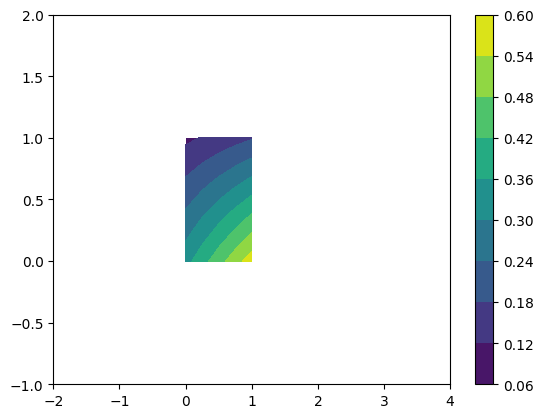

In [50]:
import matplotlib.pyplot as plt 

plt.contourf(y0, x0, samples[:,:,0])
plt.colorbar()

## check a 2D element

do we need a dummy 3rd dim? 

In [3]:
import numpy as np
from yt.utilities.lib.element_mappings import Q1Sampler2D


quad_sampler = Q1Sampler2D()

# filling a non-uniform quad
verts = [[0., 0.,], 
         [1., 0.,], 
         [0., 1.,], 
         [1., 1.,]]
verts = np.array(verts)

field_vals = np.random.random((4,))

nsamples = 10
x_samples = np.full((nsamples,), 0.5)
y_samples = np.linspace(0,1,nsamples)
positions_to_sample = np.column_stack([x_samples, y_samples])

sampled_vals = quad_sampler.sample_at_real_points(verts, field_vals, positions_to_sample)
sampled_vals

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

hmm.... maybe we need the 3rd dim?

In [5]:

# filling a non-uniform quad
verts = [[0., 0., 0. ], 
         [1., 0., 0.], 
         [0., 1., 0.], 
         [1., 1., 0.]]
verts = np.array(verts)

field_vals = np.random.random((4,))

nsamples = 10
x_samples = np.full((nsamples,), 0.5)
y_samples = np.linspace(0,1,nsamples)
z_samples = np.zeros((nsamples,))
positions_to_sample = np.column_stack([x_samples, y_samples, z_samples])
quad_sampler.sample_at_real_points(verts, field_vals, positions_to_sample)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [6]:
quad_sampler.map_reals_to_unit(verts, positions_to_sample)

array([[            nan,             nan, 2.13297482e-314],
       [            nan,             nan, 2.13297482e-314],
       [            nan,             nan, 2.13297482e-314],
       [            nan,             nan, 2.13297482e-314],
       [            nan,             nan, 2.13297482e-314],
       [            nan,             nan, 2.13297482e-314],
       [            nan,             nan, 2.13297482e-314],
       [            nan,             nan, 2.13297482e-314],
       [            nan,             nan, 2.13297482e-314],
       [            nan,             nan, 2.13297482e-314]])